In [1]:
import torch
from pprint import pprint

print("Debugging...")
def custom_repr(self):
    # return f'{{Tensor:{tuple(self.shape)}}}'
    return f'{{Tensor:{tuple(self.shape)}}} {original_repr(self)}'

original_repr = torch.Tensor.__repr__
torch.Tensor.__repr__ = custom_repr

Debugging...


In [2]:
from diffuser_actor.utils.position_encodings import SinusoidalPosEmb, RotaryPositionEncoding, RotaryPositionEncoding3D, LearnedAbsolutePositionEncoding3D, LearnedAbsolutePositionEncoding3Dv2
import matplotlib.pyplot as plt
import einops

torch.Size([100, 1, 192])


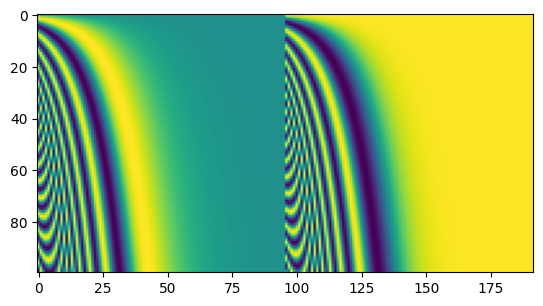

In [3]:
# Test SinusoidalPosEmb

pos_emb = SinusoidalPosEmb(192)
i = torch.arange(0, 100).unsqueeze(1)
o = pos_emb(i)
print(o.shape)
plt.imshow(o.squeeze())

torch.Size([100, 1, 192, 2])


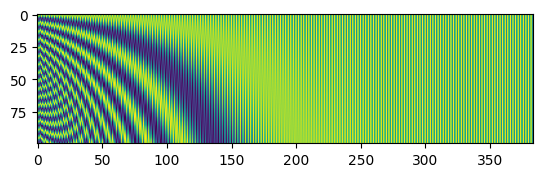

In [27]:
# tEST RotaryPositionEncoding
pos_emb = RotaryPositionEncoding(192)
i = torch.arange(0, 100).unsqueeze(1)
o = pos_emb(i)
print(o.shape)
plt.imshow(einops.rearrange(o, 'n 1 h w -> n (h w)'))

# o5 = o[5, 0]
# o11 = o[11, 0]
# o53 = o[53, 0]
# o59 = o[59, 0]

# d6_1 = torch.dot(o5, o11)
# d6_2 = torch.dot(o53, o59)
# print(d6_1, d6_2)


torch.Size([1, 200, 192, 2])


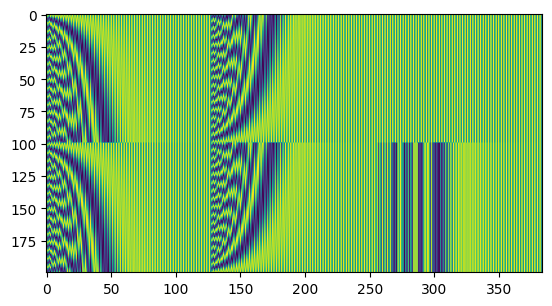

In [188]:
def show(o):
    print(o.shape)
    plt.imshow(einops.rearrange(o, '1 n h w -> n (h w)'))
# Test RotaryPositionEncoding3D
pos_emb = RotaryPositionEncoding3D(192) # 192 = 64 * 3
i = torch.zeros(1, 100, 3)
i[:, :, 0] = torch.arange(0, 100) / 100
i[:, :, 1] = torch.arange(100, 0, -1) / 100
o = pos_emb(i * 100)
i[:, :, 2] = 1
o2 = pos_emb(i * 100)
show(einops.rearrange([o, o2], 't 1 n h w -> 1 (t n) h w'))

In [162]:
from tqdm import tqdm

pos_emb = RotaryPositionEncoding(16)
ordinal_embs = pos_emb(torch.arange(0, 1024).unsqueeze(1)).to('cuda')

model = torch.nn.Sequential(
    torch.nn.Linear(64, 32),
    # torch.nn.ReLU(),
    # torch.nn.Linear(32, 32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, 32),
).to('cuda')

optim = torch.optim.Adam(model.parameters(), lr=1e-3)

bsize = 1024 * 64
max_epochs = 10000
for epoch in tqdm(range(max_epochs)):
    v = torch.randint(0, 64, (bsize, 2)).to('cuda')
    lower, upper = torch.min(v, dim=1).values.reshape(-1, 1), torch.max(v, dim=1).values.reshape(-1, 1)
    diff = upper - lower
    l_emb, u_emb = pos_emb(lower), pos_emb(upper)
    diff_emb = pos_emb(diff)

    model_input = einops.rearrange([l_emb, u_emb], 't b 1 e1 e2 -> b (t e1 e2)')
    golden = einops.rearrange(diff_emb, 'b 1 e1 e2 -> b (e1 e2)')
    out = model(model_input)

    loss = torch.nn.functional.mse_loss(out, golden)
    optim.zero_grad()
    loss.backward()
    if epoch % 1000 == 0:
        print(loss.item())
    optim.step()




  1%|          | 71/10000 [00:00<00:27, 362.31it/s]

0.5388071537017822


 11%|█         | 1054/10000 [00:02<00:19, 460.16it/s]

0.01673462986946106


 21%|██        | 2088/10000 [00:04<00:17, 464.02it/s]

0.011272766627371311


 31%|███       | 3075/10000 [00:06<00:15, 461.03it/s]

0.010199373587965965


 41%|████      | 4060/10000 [00:08<00:12, 459.23it/s]

0.009871312417089939


 51%|█████     | 5092/10000 [00:11<00:10, 465.28it/s]

0.0049975356087088585


 61%|██████    | 6079/10000 [00:13<00:08, 463.99it/s]

0.004721429198980331


 71%|███████   | 7066/10000 [00:15<00:06, 463.93it/s]

0.0046842703595757484


 81%|████████  | 8053/10000 [00:17<00:04, 463.51it/s]

0.00459836283698678


 90%|█████████ | 9047/10000 [00:19<00:02, 458.28it/s]

0.004531376529484987


100%|██████████| 10000/10000 [00:21<00:00, 462.04it/s]


/tmp/ipykernel_2488493/29445115.py:10: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([1, 32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = torch.nn.functional.mse_loss(out, golden)


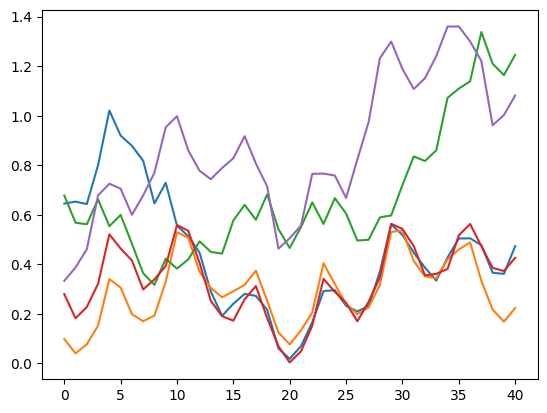

In [172]:
# test model
def test(u, l, d):
    ue, le = ordinal_embs[u], ordinal_embs[l]
    de = ordinal_embs[d]

    model_input = einops.rearrange([le, ue], 't 1 e1 e2 -> (t e1 e2)')
    golden = einops.rearrange(de, '1 e1 e2 -> (e1 e2)')
    with torch.no_grad():
        out = model(model_input.unsqueeze(0))
        loss = torch.nn.functional.mse_loss(out, golden)
        return loss.item()


res = [test(20, 10 + (i-20), 10) for i in range(0, 41)]
plt.plot(res)
res = [test(80, 70 + (i-20), 10) for i in range(0, 41)]
plt.plot(res)
res = [test(700, 690 + (i-20), 10) for i in range(0, 41)]
plt.plot(res)
res = [test(34, 29 + (i-20), 5) for i in range(0, 41)]
plt.plot(res)
res = [test(234, 229 + (i-20), 5) for i in range(0, 41)]
plt.plot(res)